In [2]:
import rasterio
path = "s3://planet-snowcover-analysis/ASO_3M_SD_USCATE_20190705/ASO_3M_SD_USCATE_20190705.tif"
with rasterio.Env(AWS_S3_ENDPOINT='s3.us-west-2.amazonaws.com'):
    with rasterio.open(path) as f:
        img = f.read()

In [3]:
import boto3
session = boto3.Session(profile_name='esip')
# Any clients created from this session will use credentials
# from the [dev] section of ~/.aws/credentials.
dev_s3_client = session.client('s3')


In [6]:
with open('ASO_3M_SD_USCATE_20190705.tif', 'wb') as f:
    dev_s3_client.download_fileobj('planet-snowcover-analysis', 
                                   'ASO_3M_SD_USCATE_20190705/ASO_3M_SD_USCATE_20190705.tif', f)

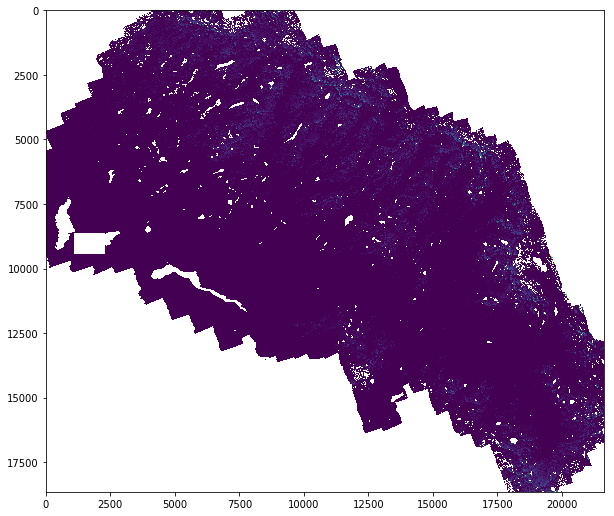

In [7]:
%matplotlib inline
import rasterio as rio
import numpy as np
from matplotlib import pyplot as plt
import rasterio.plot
import os
from datetime import datetime as dt

# Load the DEM and read out a np array of the elevation values (meters):
dem = rio.open(r'ASO_3M_SD_USCATE_20190705.tif')
elev = dem.read(1)



# Plot this elevation band:
plt.figure(figsize=(10,10))
plt.imshow(elev)

title_text = ''
plt.title(title_text);


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


ValueError: max must be larger than min in range parameter.

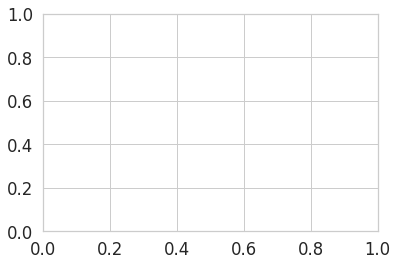

In [23]:
plt.hist(elev)

In [8]:
elev

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [9]:
# get metadata
dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 21623,
 'height': 18653,
 'count': 1,
 'crs': CRS.from_epsg(32611),
 'transform': Affine(3.0, 0.0, 242715.0,
        0.0, -3.0, 4234848.0)}

In [10]:
!gdalinfo ASO_3M_SD_USCATE_20190705.tif

Driver: GTiff/GeoTIFF
Files: ASO_3M_SD_USCATE_20190705.tif
Size is 21623, 18653
Coordinate System is:
PROJCS["WGS 84 / UTM zone 11N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32611"]]
Origin = (242715.000000000000000,4234848.000000000000000)
Pixel Size = (3.000000000000000,-3.000000000000000)
Metadata:
  AREA_OR

In [11]:
import seaborn as sns

In [12]:
dem.bounds

BoundingBox(left=242715.0, bottom=4178889.0, right=307584.0, top=4234848.0)

In [13]:
#clip the area of interest
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask


In [14]:
dst_crs='EPSG:4326'
transform, width, height = calculate_default_transform(dem.crs, dst_crs, dem.width, dem.height, *dem.bounds)
kwargs = dem.meta.copy()
kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

In [15]:
outpath='ASO_3M_SD_USCATE_20190705_4326.tiff'
with rio.open(outpath, 'w', **kwargs) as dst:
            reproject(
                        source=rio.band(dem, 1),
                        destination=rio.band(dst, 1),
                        src_transform=dem.transform,
                        src_crs=dem.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.bilinear)

In [1]:
# Open raster data
import earthpy as et
import earthpy.plot as ep

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [16]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

In [18]:
# Open data and assign negative values to nan
with rio.open('ASO_3M_SD_USCATE_20190705_4326.tiff') as src:
    epsg4326_dem = src.read(1, masked=True)
ds = rio.open('ASO_3M_SD_USCATE_20190705_4326.tiff')
print(ds.crs)
print(ds.meta)
# View object dimensions
epsg4326_dem.shape

EPSG:4326
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 23991, 'height': 16511, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(3.148933938831482e-05, 0.0, -119.93913483662392,
       0.0, -3.148933938831482e-05, 38.24106453792271)}


(16511, 23991)

In [19]:
print(epsg4326_dem)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


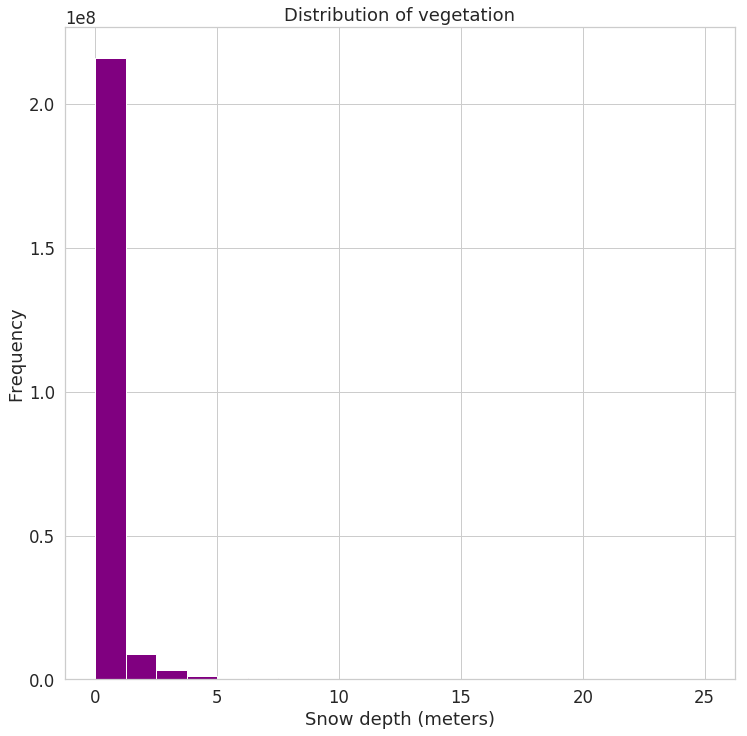

In [24]:
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
ep.hist(epsg4326_dem, colors=['purple'],
        title="Distribution of vegetation",
        xlabel='Snow depth (meters)',
        ylabel='Frequency')
plt.show()

In [22]:
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import numpy
scale=1
# Open data and assign negative values to nan

with rio.open('ASO_3M_SD_USCATE_20190705_4326.tiff') as src:
            t = src.transform
            # # binary
            planet_mask = src.read(1) > 0.1 
            
            # dtype byte profile (integer)
            aug_pla_meta = src.profile
            # Change the count or number of bands from 4 to 5
            aug_pla_meta['count'] = 1
            # Change the data type to float rather than integer
            aug_pla_meta['dtype'] = "float64"
            aug_pla_meta
            
            #convert to float64 -  byte
            ndvi_64 = np.array(planet_mask, dtype=numpy.float64)


            # Write band calculations to a new raster file
            with rasterio.open('ASO_3M_SD_USCATE_20190705_4326_binary.tiff', 'w', **aug_pla_meta) as dstr:
                    dstr.write_band(1, ndvi_64)
            dstr.close() 

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


In [32]:
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import numpy
scale=1
# Open data and assign negative values to nan

with rio.open('ASO_3M_SD_USCATE_20190705_4326.tiff') as src:
            t = src.transform
            # # binary
            planet_mask = src.read(1) > 0.1 
            
            # dtype byte profile (integer)
            aug_pla_meta = src.profile
            # Change the count or number of bands from 4 to 5
            aug_pla_meta['count'] = 1
            # Change the data type to float rather than integer
            aug_pla_meta['dtype'] = "int8"
            aug_pla_meta
            
            #convert to float64 -  byte
            ndvi_64 = np.array(planet_mask, dtype=numpy.byte)


            # Write band calculations to a new raster file
            with rasterio.open('ASO_3M_SD_USCATE_20190705_4326_binary_byte.tiff', 'w', **aug_pla_meta) as dstr:
                    dstr.write_band(1, ndvi_64)
            dstr.close() 

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
